## Write Python code to implement ID3 algorithm and test it on the PlayTennis dataset and verify inductive bias of decision tree learning algorithm.

In [1]:
import pandas as pd
import numpy as np

D:\Programming_software_Install\Anaconda\envs\Deeplearning\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Programming_software_Install\Anaconda\envs\Deeplearning\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Programming_software_Install\Anaconda\envs\Deeplearning\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## Using Custom code

In [2]:
# Define the dataset
df = pd.read_csv('../Datasets/PlayTennis.csv')
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


## Requried functions for ID3 model

In [5]:
# Step 1: Calculate Entropy
def calculate_entropy(data):
    label_counts = Counter(data)
    total = len(data)
    entropy = 0.0
    for count in label_counts.values():
        prob = count / total
        entropy -= prob * math.log2(prob)
    return entropy

# Step 2: Calculate Information Gain
def calculate_information_gain(data, feature, target):
    # Calculate the entropy of the target variable
    target_entropy = calculate_entropy(data[target])
    
    # Split the data by feature values
    feature_values = data[feature].unique()
    weighted_entropy = 0.0
    
    for value in feature_values:
        # Subset where the feature equals the current value
        subset = data[data[feature] == value]
        # Calculate the entropy for the subset
        subset_entropy = calculate_entropy(subset[target])
        # Weight the subset entropy by the fraction of total instances
        weighted_entropy += (len(subset) / len(data)) * subset_entropy
    
    # Information Gain is the difference between the original entropy and weighted entropy
    return target_entropy - weighted_entropy

# Step 3: Select the best feature with the highest Information Gain
def select_best_feature(data, features, target):
    best_feature = None
    best_gain = -float('inf')
    
    for feature in features:
        gain = calculate_information_gain(data, feature, target)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
    
    return best_feature

# Step 4: Build the Decision Tree
def id3(data, features, target):
    # If all instances have the same label, return that label
    if data[target].nunique() == 1:
        return data[target].iloc[0]
    
    # If no features left to split on, return the most common label
    if len(features) == 0:  # Use `len(features)` to check if the feature set is empty
        return data[target].mode()[0]
    
    # Select the best feature
    best_feature = select_best_feature(data, features, target)
    
    # Create a tree with the best feature as the root
    tree = {best_feature: {}}
    
    # Remove the best feature from the list of features
    remaining_features = [f for f in features if f != best_feature]
    
    # Recursively build the tree for each value of the best feature
    feature_values = data[best_feature].unique()
    for value in feature_values:
        subset = data[data[best_feature] == value]
        tree[best_feature][value] = id3(subset, remaining_features, target)
    
    return tree

# Function to print the decision tree
def print_tree(tree, indent=""):
    if isinstance(tree, dict):
        for key, value in tree.items():
            print(f"{indent}{key}:")
            print_tree(value, indent + "  ")
    else:
        print(f"{indent}{tree}")

# Predict for new sample data        
def predict(tree, sample):
    # If the tree is a leaf node, return the class label
    if not isinstance(tree, dict):
        return tree
    
    # Iterate through the tree to find the next feature
    for feature, branches in tree.items():
        # Get the value of the feature for the sample
        value = sample.get(feature)
        if value in branches:
            # Recursively call predict on the corresponding subtree
            return predict(branches[value], sample)
        else:
            # If the feature value isn't in the tree, return a default (e.g., "Unknown")
            return "Unknown"

## Train the tree model with K-Fold cross validation

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import math
from collections import Counter

# Applying k-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(df):
    # Split into training and testing sets
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]
    
    # Extract features and target
    features = df.columns[:-1]  # All columns except the target
    target = 'play'
    
    # Train the ID3 decision tree
    tree = id3(train_data, features, target)
    
    # Test the model on the testing set
    y_true = []
    y_pred = []
    
    for _, row in test_data.iterrows():
        sample = row[features].to_dict()  # Convert row features to a dictionary
        actual = row[target]             # Actual label
        predicted = predict(tree, sample)  # Predicted label
        
        y_true.append(actual)
        y_pred.append(predicted)
    
    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_true, y_pred)
    accuracies.append(accuracy)

In [10]:
print(print_tree(tree))
# Print the average accuracy across all folds
print(f"Cross-Validated Accuracy: {sum(accuracies) / len(accuracies):.2f}")

outlook:
  sunny:
    humidity:
      high:
        no
      normal:
        yes
  overcast:
    yes
  rainy:
    windy:
      False:
        yes
      True:
        no
None
Cross-Validated Accuracy: 0.87


## Custom model - visualization

In [1]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to visualize the tree using Graphviz
def draw_tree(tree, parent_name, graph):
    if isinstance(tree, dict):
        for feature, sub_tree in tree.items():
            # Create a node for this feature
            node_name = str(hash(feature))
            graph.node(node_name, feature)
            graph.edge(parent_name, node_name)
            
            # Recursively process the sub-trees
            for value, sub_sub_tree in sub_tree.items():
                value_name = str(hash(value))
                graph.node(value_name, f"{feature}={value}")
                graph.edge(node_name, value_name)
                draw_tree(sub_sub_tree, value_name, graph)
    else:
        # Leaf node (class label)
        leaf_name = str(hash(tree))
        graph.node(leaf_name, str(tree), shape="box")
        graph.edge(parent_name, leaf_name)

# Initialize the graph
dot = Digraph(comment='Decision Tree')

# Set the size of the tree (width and height)
dot.attr(dpi='300', size='10,10')  # Adjust the size here

# Start drawing from the root
dot.node('root', 'Root')
draw_tree(tree, 'root', dot)

# Render the tree to a temporary file
dot.format = 'png'
dot.render('/tmp/decision_tree')  # Temporary file on disk

# Use matplotlib to display the saved image with specific size
img = mpimg.imread('/tmp/decision_tree.png')
plt.figure(figsize=(12, 12))  # Adjust this figure size as needed
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

D:\Programming_software_Install\Anaconda\envs\Deeplearning\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Programming_software_Install\Anaconda\envs\Deeplearning\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Programming_software_Install\Anaconda\envs\Deeplearning\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


NameError: name 'tree' is not defined

## Test the the Decision tree model with new data

In [17]:

# Example test sample
test_sample = {'outlook': 'sunny', 'temperature': 'hot', 'humidity': 'high', 'wind': 'weak'}

# Predict the class label
prediction = predict(tree, test_sample)
print(f"Predicted Class: {prediction}")

Predicted Class: no


## Using sklearn

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('../Datasets/PlayTennis.csv')

# Encode categorical data
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':  # Encode only object-type columns
        df[column] = le.fit_transform(df[column])

# Split features and target
X = df.drop(columns="play")  # Features
y = df["play"]               # Target

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Method 1: Using cross_val_score
scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
print(f"Using sklearn - Cross-Validated Accuracy (Method 1): {scores.mean():.2f}")

# Method 2: Using KFold for manual splitting
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracies.append(accuracy_score(y_test, y_pred))

print(f"Using sklearn - Cross-Validated Accuracy (Method 2): {sum(accuracies) / len(accuracies):.2f}")


Using sklearn - Cross-Validated Accuracy (Method 1): 0.87
Using sklearn - Cross-Validated Accuracy (Method 2): 0.70


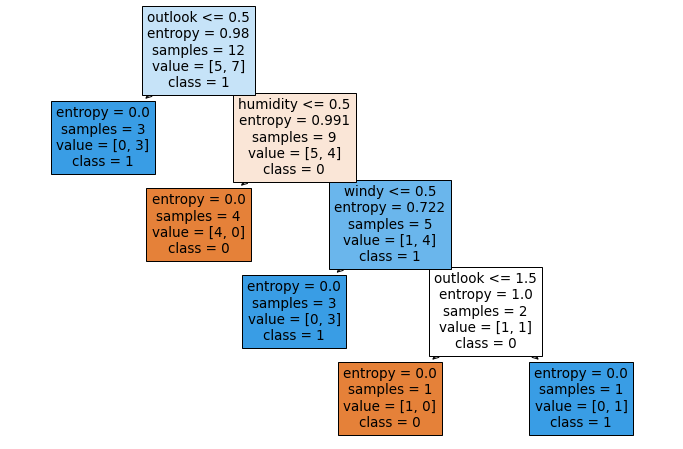

In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Ensure feature names and class names are in string format
features_str = [str(f) for f in X.columns]
class_names_str = [str(cls) for cls in clf.classes_]

# Plot the decision tree
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plot_tree(clf, feature_names=features_str, class_names=class_names_str, filled=True)
plt.show()
